In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from bmadx.plot import plot_projections
from bmadx.pmd_utils import openpmd_to_bmadx_beam, bmadx_beam_to_openpmd
from phase_space_reconstruction.analysis import screen_stats, get_beam_fraction_bmadx_beam, get_beam_fraction_bmadx_particle

In [2]:
data_dir = os.path.join('data', 'non_gaussian_beam')
t_scan_dir = os.path.join(data_dir, 't_scan')
n_par_dir = os.path.join(data_dir, 'n_par')

# Number of particles study

In [3]:
# ground truth beam:
gt =  torch.load(os.path.join(n_par_dir, 'non_gaussian_beam.pt')).numpy_particles()
# reconstructions:
r_1e4 = torch.load(os.path.join(n_par_dir, '3D_scan_10_000.pt')).numpy_particles()
r_1e5 = torch.load(os.path.join(n_par_dir, '3D_scan_100_000.pt')).numpy_particles()
r_1e6 = torch.load(os.path.join(n_par_dir, '3D_scan_1_000_000.pt')).numpy_particles()
np.shape(np.stack(gt[:6]))

(6, 1000000)

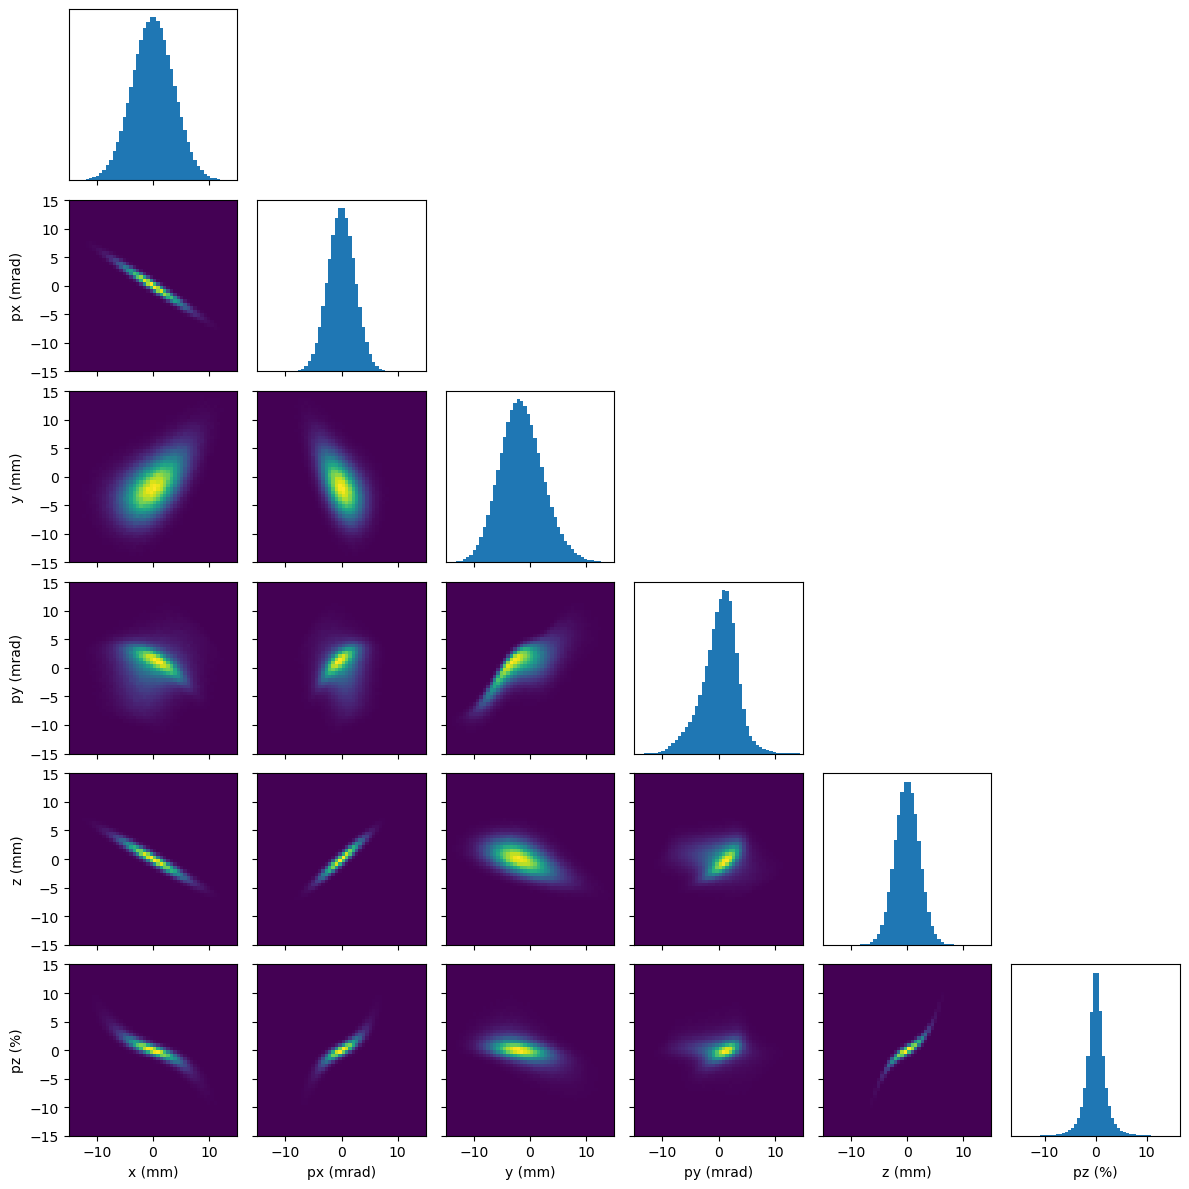

In [4]:
# plot gt:
lims = np.array([
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-15e-2,15e-2]
])
plot_projections(gt, custom_lims=lims)
plt.show()

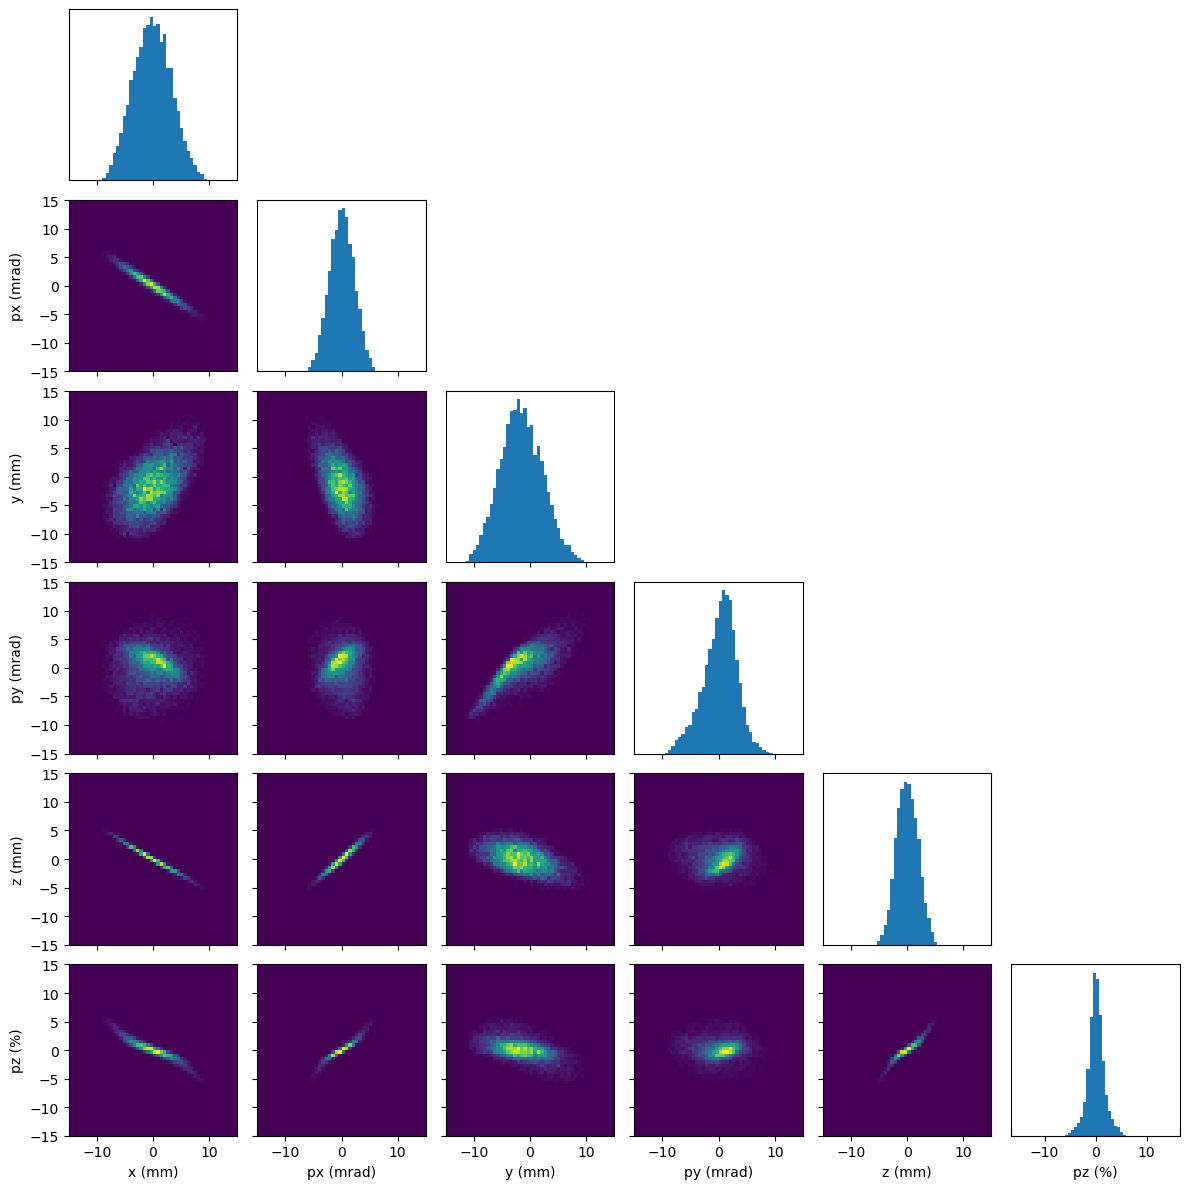

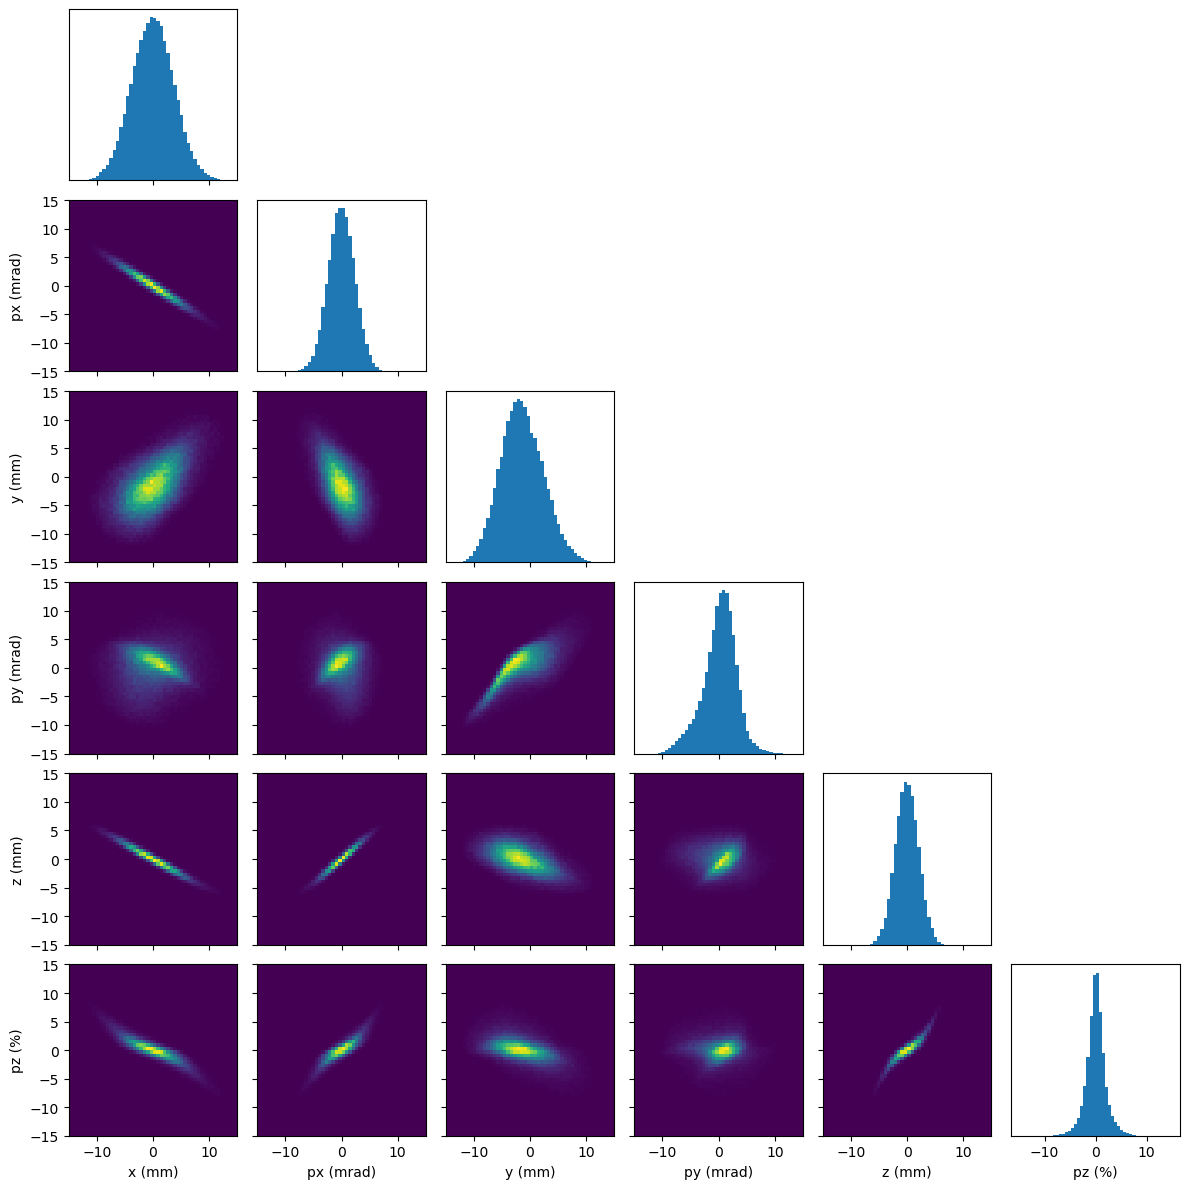

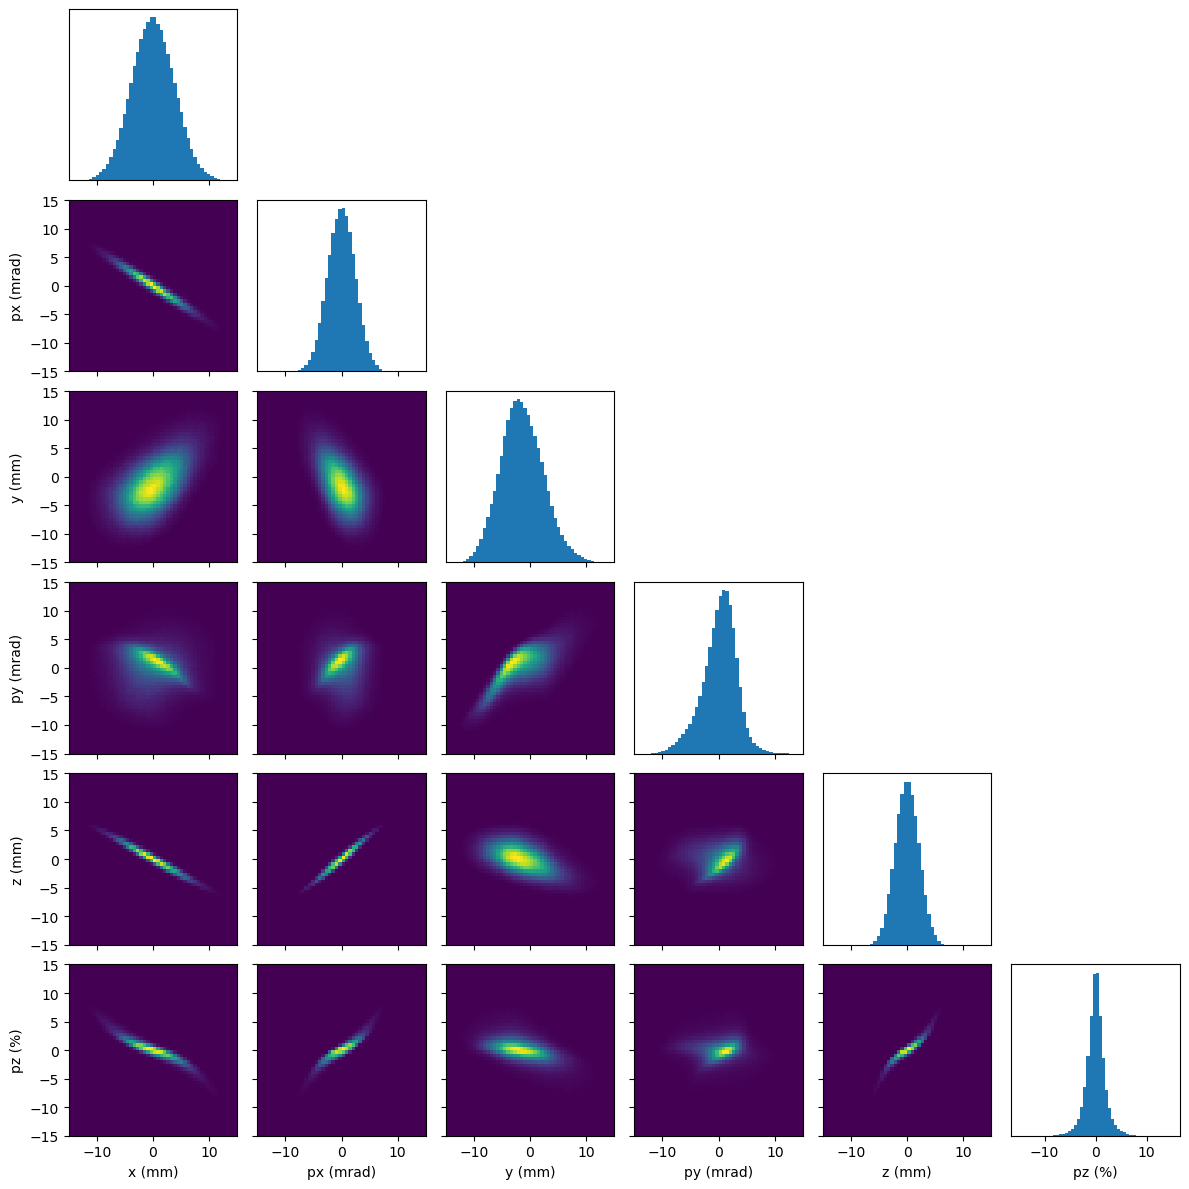

In [5]:
# plot recontructions:
plot_projections(r_1e4, custom_lims=lims)
plt.show()
plot_projections(r_1e5, custom_lims=lims)
plt.show()
plot_projections(r_1e6, custom_lims=lims)
plt.show()

In [6]:
#gt_frac_50 = get_beam_fraction_from_projection(gt, ('y','py'),0.5)
gt_frac_50 = get_beam_fraction_bmadx_particle(gt, 0.5)
gt_frac_90 = get_beam_fraction_bmadx_particle(gt, 0.9)
gt_frac_95 = get_beam_fraction_bmadx_particle(gt, 0.95)
print(len(gt_frac_50.x))
print(len(gt_frac_90.x))
print(len(gt_frac_95.x))

500000
900000
950000


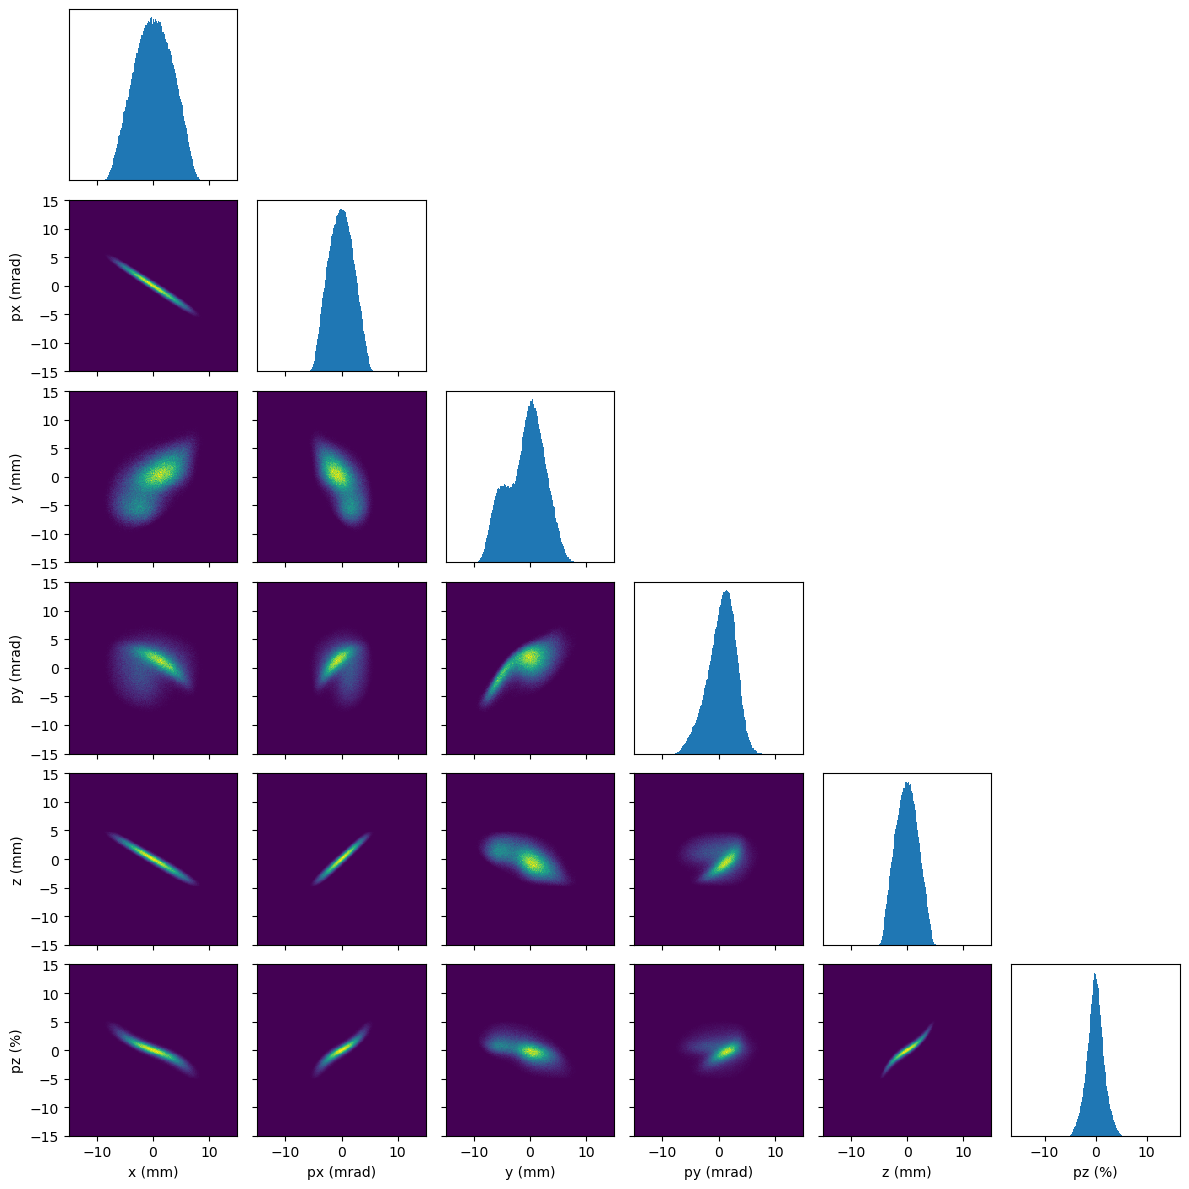

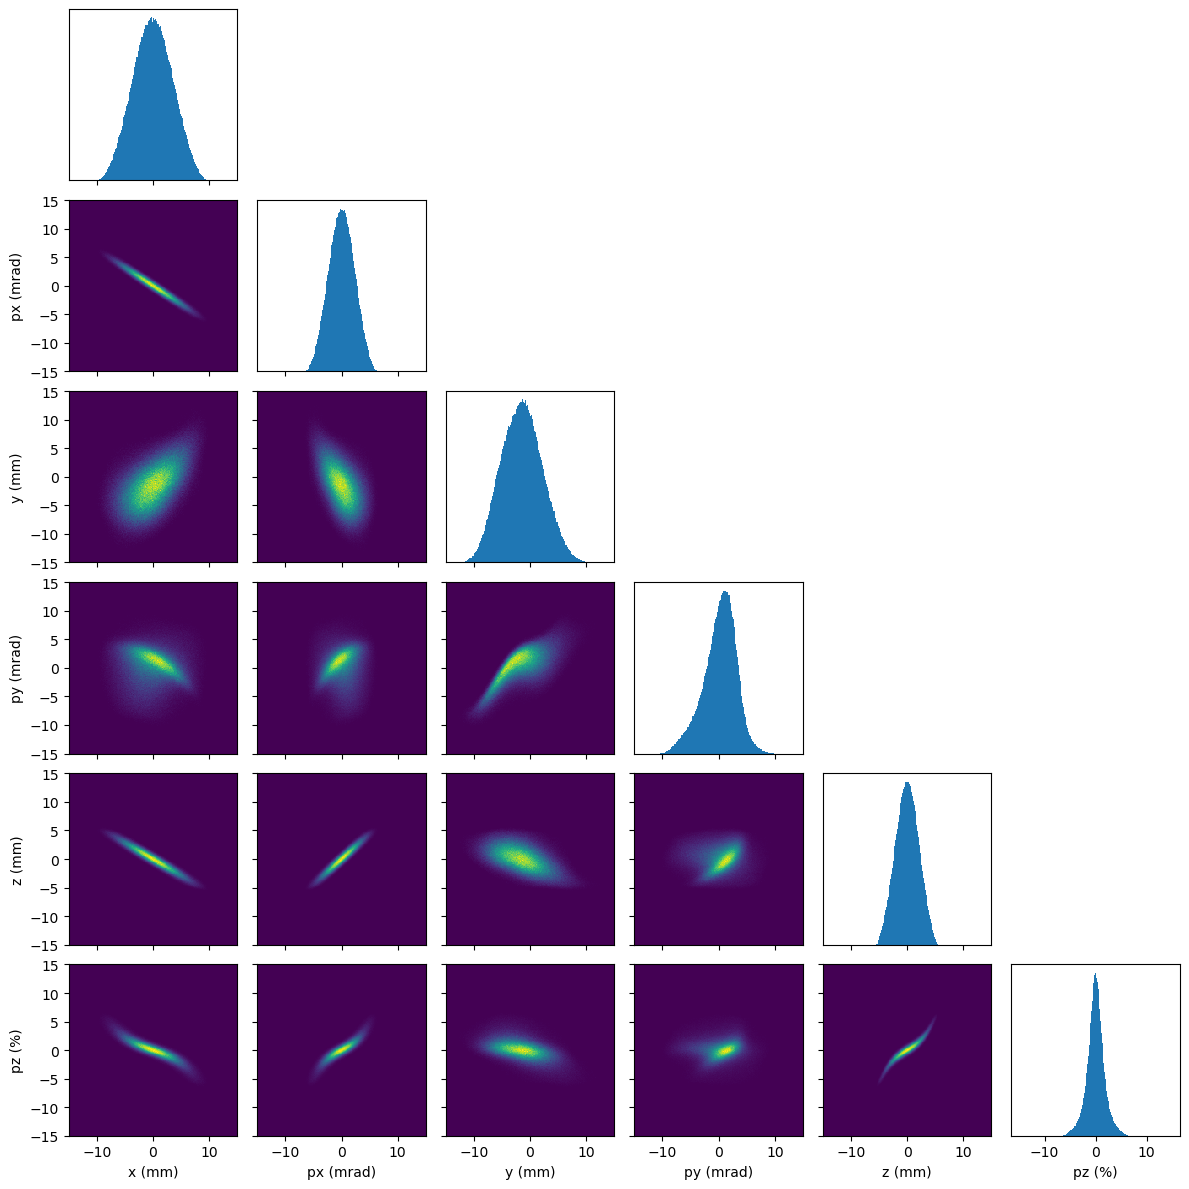

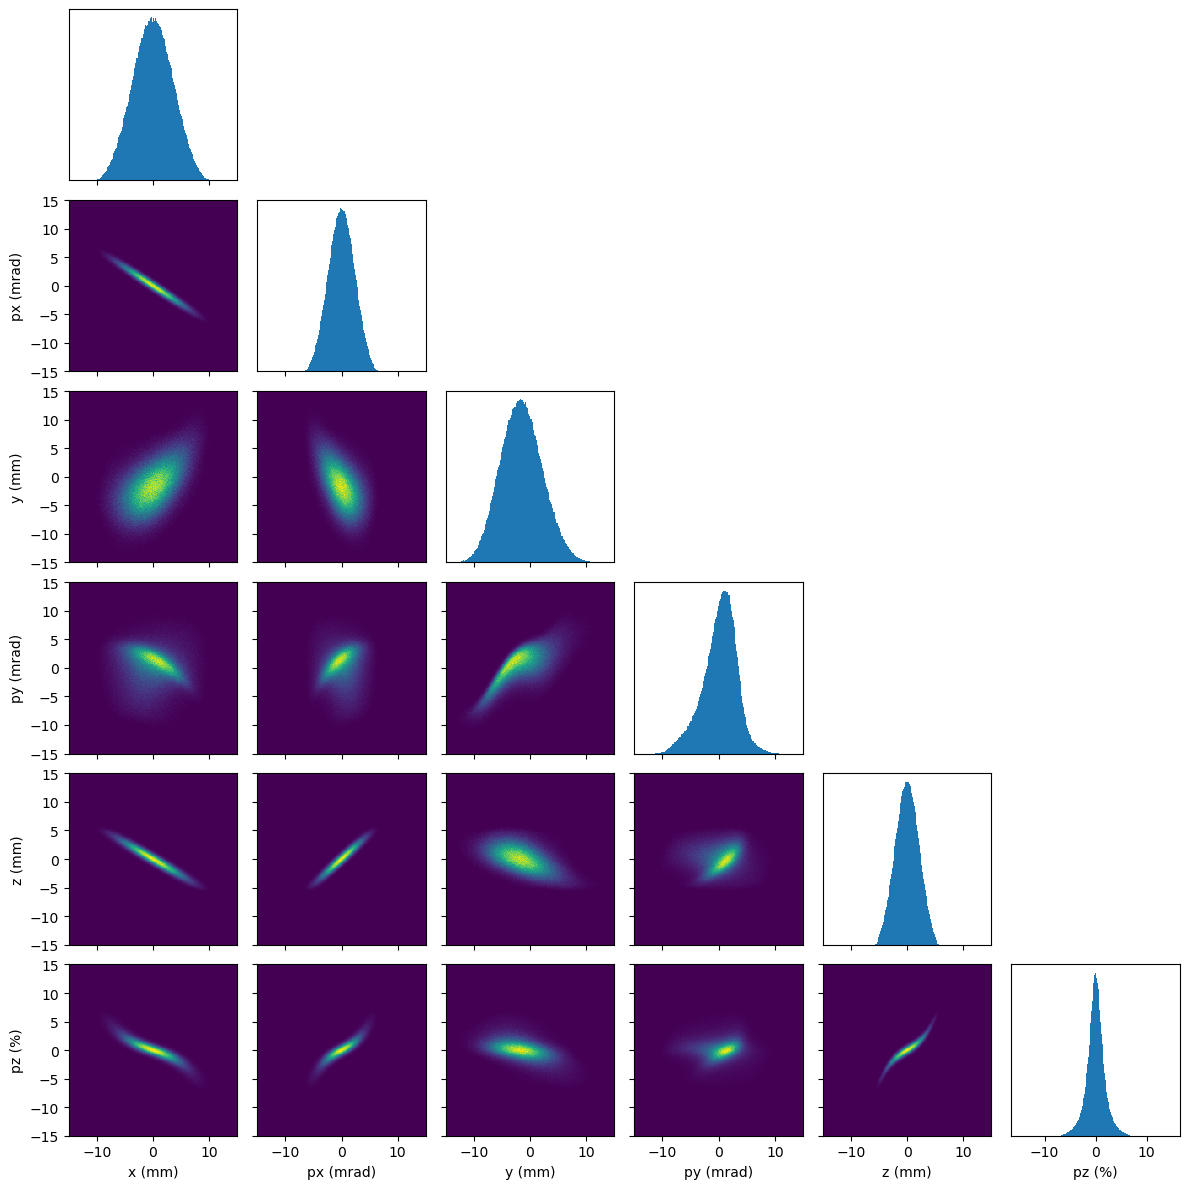

In [7]:
plot_projections(gt_frac_50, custom_lims=lims, bins=200)
plt.show()
plot_projections(gt_frac_90, custom_lims=lims, bins=200)
plt.show()
plot_projections(gt_frac_95, custom_lims=lims, bins=200)
plt.show()

In [8]:
from scipy.ndimage import gaussian_filter
from bmadx.structures import Particle

def get_beam_fraction_from_projection(
        beam_distribution: Particle,
        axes: list,
        beam_fraction: float
):
    """ get core of the beam according to 6D normalized beam coordinates"""
    full_coords = np.stack(beam_distribution[:6]).T
    data = np.copy(np.stack([getattr(beam_distribution, ax) for ax in axes]).T)
    cov = np.cov(data.T)

    # get inverse cholesky decomp
    t_data = (np.linalg.inv(np.linalg.cholesky(cov)) @ data.T).T

    J = np.linalg.norm(t_data, axis=1)
    sort_idx = np.argsort(J)
    frac_coords = full_coords[sort_idx][:int(len(full_coords) * beam_fraction)]
    frac_particle = Particle(
        *frac_coords.T,
        p0c = beam_distribution.p0c,
        s = beam_distribution.s,
        mc2 = beam_distribution.mc2
    )

    return frac_particle

def get_beam_fraction_hist2d(hist2d, fraction: float):
    levels = np.linspace(hist2d.max(), 0.0, 100)
    total = hist2d.sum()
    final_beam = np.copy(hist2d)
    for level in levels:
        test_beam = np.where(hist2d>=level, hist2d, 0.0)
        test_frac = test_beam.sum() / total
        if test_frac > fraction:
            final_beam = test_beam
            break

    return final_beam

def plot_projections_with_contours(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 90],
        contour_smoothing_r = 1,
        contour_smoothing_gt = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size, dpi=300)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)

    for i in range(n_coords):
        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale

        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x])
        )
        
        ax[i,i].yaxis.set_tick_params(left=False, labelleft=False)

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):
            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            rng=[[min_x, max_x],[min_y, max_y]]
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range = rng,
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k, percentile in enumerate(contour_percentiles):
                #r_fractions = get_beam_fraction_from_projection(
                #        reconstruction, 
                #        [x_coord, y_coord],
                #        percentile/100
                #)

                #h_r_fractions, _, _ = np.histogram2d(
                #    getattr(r_fractions, x_coord)*scale,
                #    getattr(r_fractions, y_coord)*scale,
                #    bins = bins,
                #    range = rng
                #)
                h_r_fractions = get_beam_fraction_hist2d(hist, percentile/100)
                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                    #h_r_fractions.T,
                    levels=[1],
                    linestyles="-",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    #gt_fractions = get_beam_fraction_from_projection(
                    #        ground_truth, 
                    #        [x_coord, y_coord],
                    #        percentile/100
                    #)

                    #h_gt_fractions, _, _ = np.histogram2d(
                    #    getattr(gt_fractions, x_coord)*scale,
                    #    getattr(gt_fractions, y_coord)*scale,
                    #    bins = bins,
                    #    range = rng
                    #)
                    h_gt, _, _ = np.histogram2d(
                        getattr(ground_truth, x_coord)*scale,
                        getattr(ground_truth, y_coord)*scale,
                        bins = bins,
                        range = rng
                    )
                    h_gt_fractions = get_beam_fraction_hist2d(h_gt, percentile/100)

                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        #h_gt_fractions.T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[k],
                        linewidths=1
                    )  



            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])
            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax


def plot_projections_with_contours2(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 90],
        contour_smoothing_r = 1,
        contour_smoothing_gt = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)


    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    gt_fractions = []
    r_fractions = []
    for percentile in contour_percentiles:
        r_fractions.append(
            get_beam_fraction_from_projection(
                reconstruction, 
                ('x', 'px', 'y', 'py', 'z', 'pz'),
                percentile/100)
        )

        if ground_truth is not None:
            gt_fractions.append(
                get_beam_fraction_from_projection(
                    ground_truth, 
                    ('x', 'px', 'y', 'py', 'z', 'pz'),
                    percentile/100)
            )
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)
    for i in range(n_coords):

        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale
        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x])
            )
        
        ax[i,i].yaxis.set_tick_params(
            left=False, 
            labelleft=False
            )

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):

            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range=[[min_x, max_x],
                        [min_y, max_y]],
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k in range(n_contours):
                
                h_r_fractions, _, _ = np.histogram2d(
                    getattr(r_fractions[k], x_coord)*scale,
                    getattr(r_fractions[k], y_coord)*scale,
                    bins = bins,
                    range = [[min_x, max_x],[min_y, max_y]]
                )

                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                    levels=[1],
                    linestyles="-",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    h_gt_fractions, _, _ = np.histogram2d(
                        getattr(gt_fractions[k], x_coord)*scale,
                        getattr(gt_fractions[k], y_coord)*scale,
                        bins = bins,
                        range = [[min_x, max_x],[min_y, max_y]]
                    )
                    
                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[k],
                        linewidths=1
                    )
                    

            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])

            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax


6


/tmp/ipykernel_6689/2807903281.py:209: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


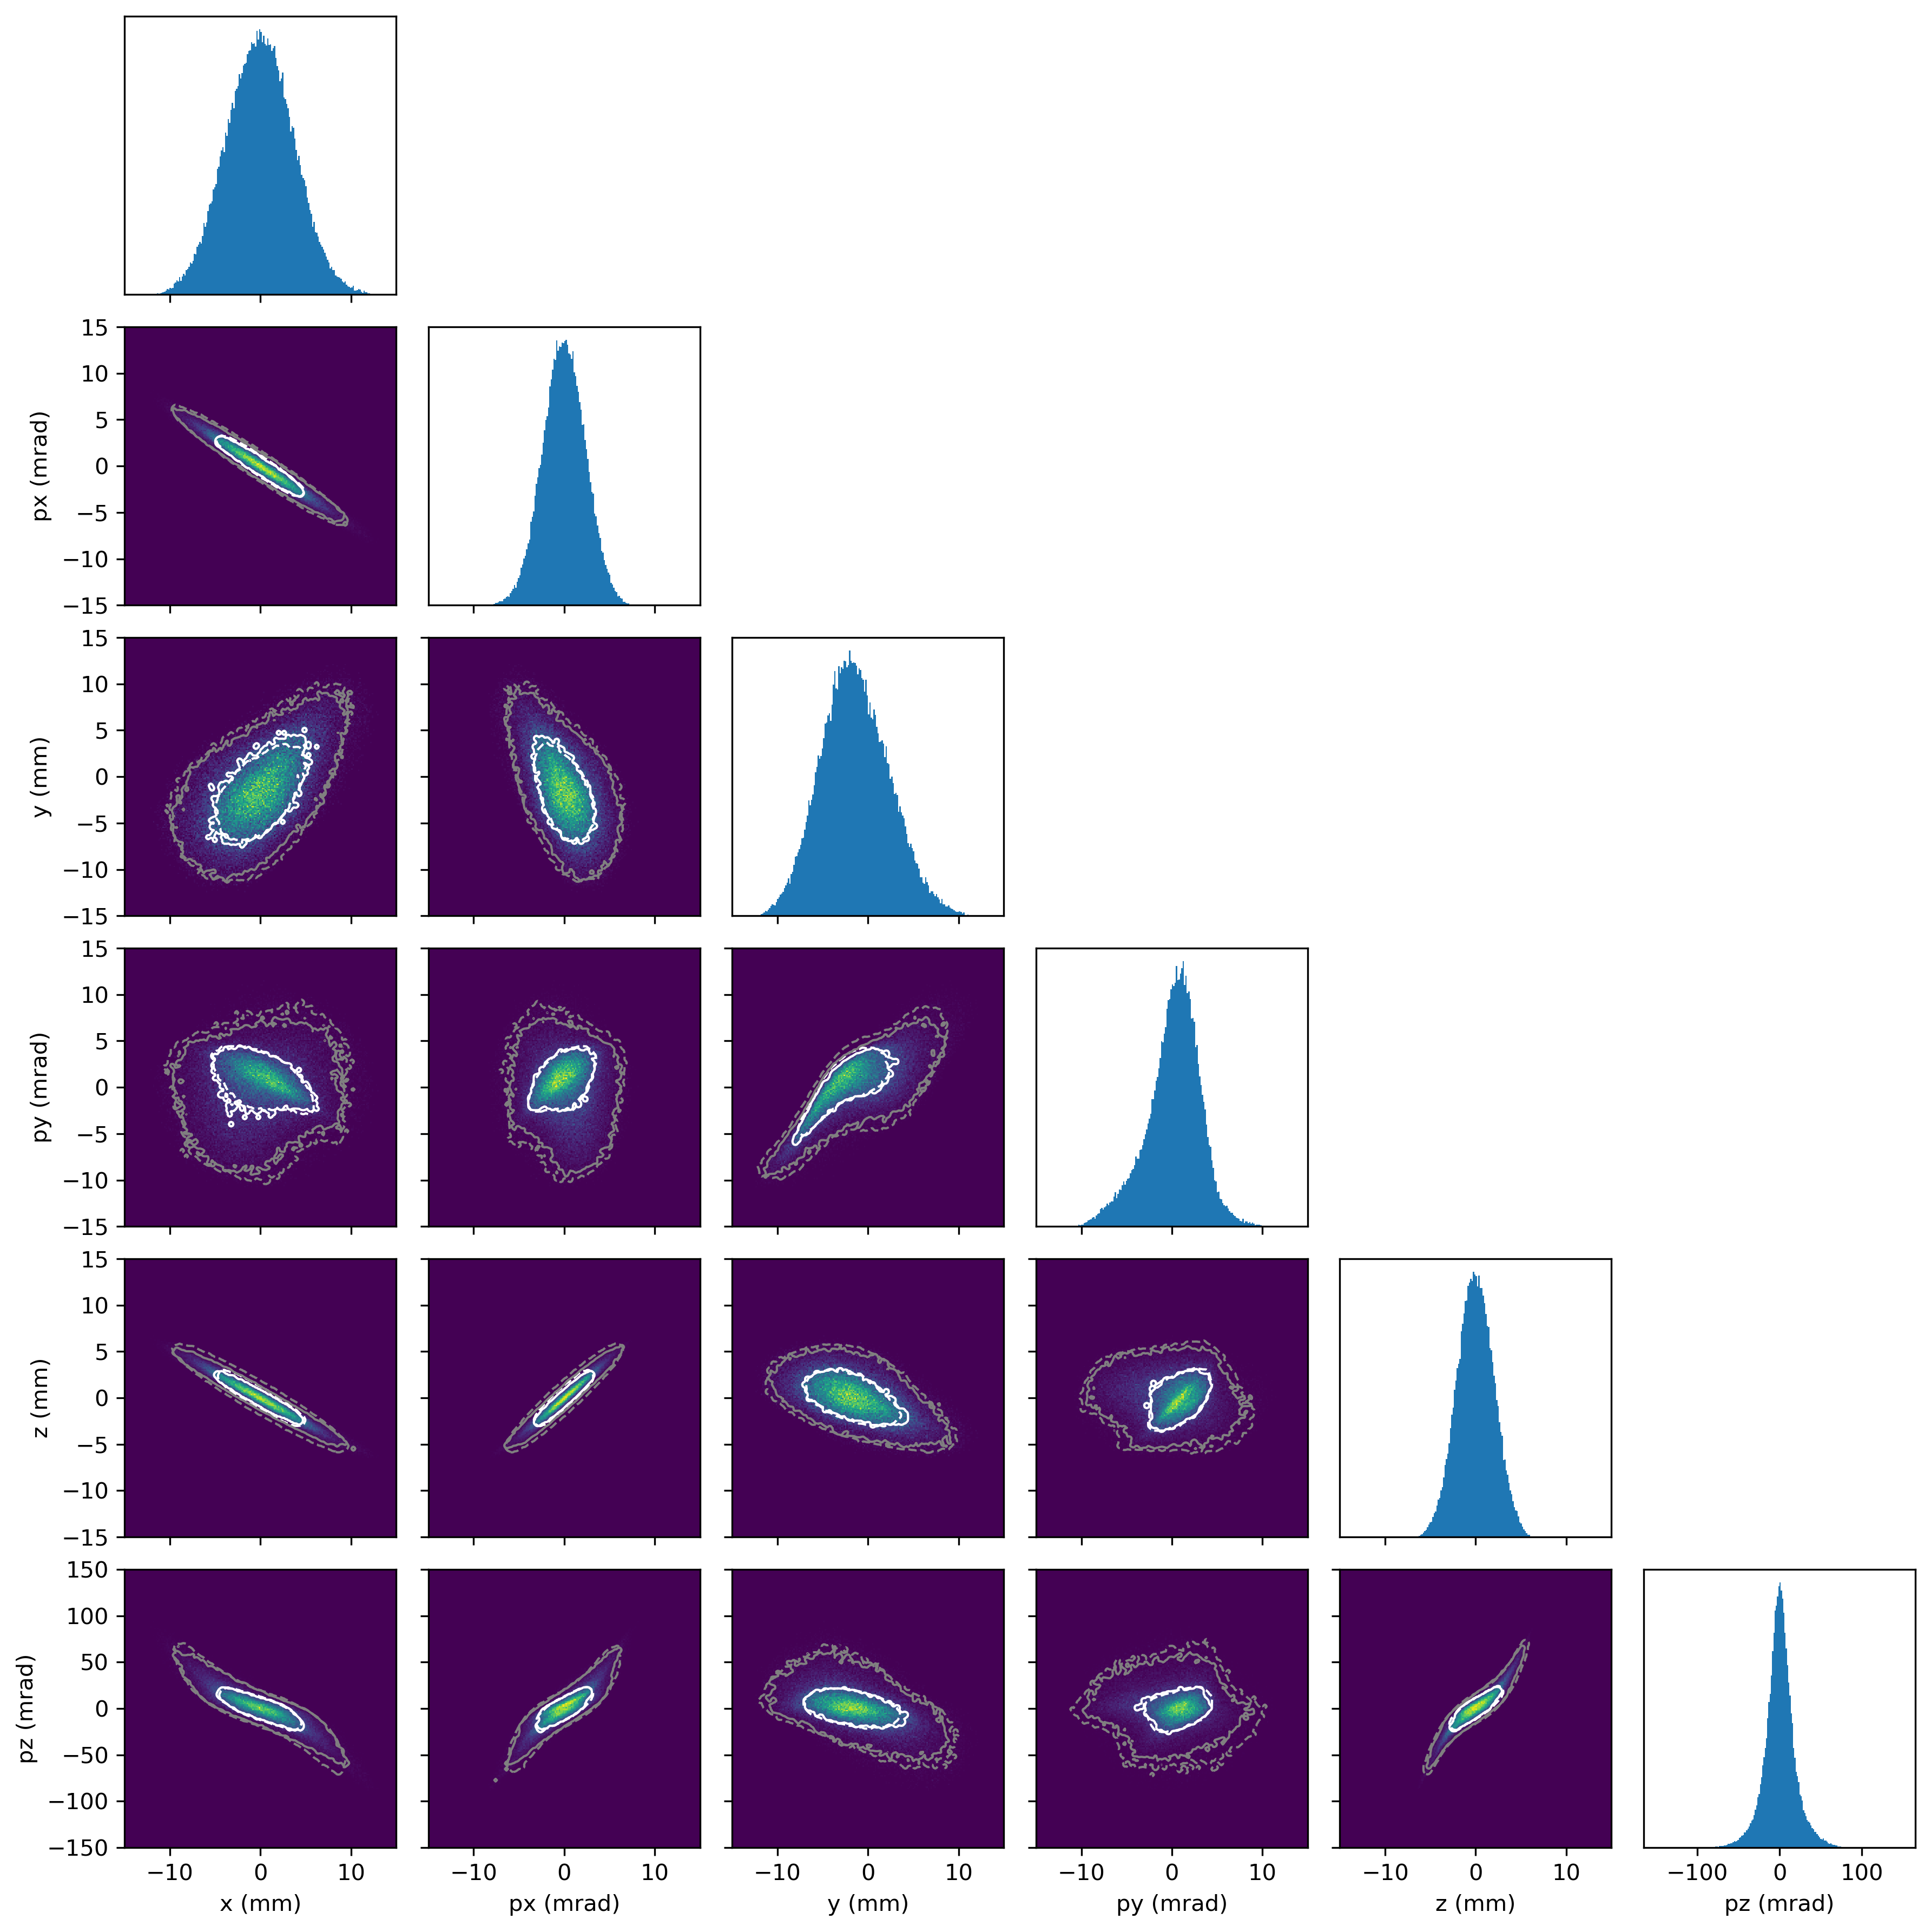

In [9]:
plot_projections_with_contours(
    r_1e5,
    gt,
    bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=1,
    contour_smoothing_gt=1
)
plt.show()

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(np.cov(r_1e4[:6])*1e6)
print(np.cov(r_1e5[:6])*1e6)
print(np.cov(r_1e6[:6])*1e6)
print(np.cov(gt[:6])*1e6)

[[11.041 -7.005 6.114 -0.682 -6.217 -50.324]
 [-7.005 4.658 -3.991 0.406 3.976 33.391]
 [6.114 -3.991 13.713 8.420 -3.422 -30.244]
 [-0.682 0.406 8.420 8.937 0.302 0.887]
 [-6.217 3.976 -3.422 0.302 3.531 28.911]
 [-50.324 33.391 -30.244 0.887 28.911 255.591]]
[[13.616 -8.437 7.964 0.235 -7.300 -62.823]
 [-8.437 5.478 -4.971 -0.114 4.629 39.509]
 [7.964 -4.971 14.101 8.493 -4.089 -36.240]
 [0.235 -0.114 8.493 8.820 0.162 0.239]
 [-7.300 4.629 -4.089 0.162 4.090 35.761]
 [-62.823 39.509 -36.240 0.239 35.761 354.340]]
[[14.105 -8.921 7.556 -0.712 -7.639 -64.157]
 [-8.921 5.923 -4.834 0.434 4.949 41.570]
 [7.556 -4.834 14.117 8.260 -3.947 -35.663]
 [-0.712 0.434 8.260 9.190 0.614 2.917]
 [-7.639 4.949 -3.947 0.614 4.289 35.955]
 [-64.157 41.570 -35.663 2.917 35.955 331.179]]
[[13.562 -8.660 7.807 -0.581 -7.684 -69.245]
 [-8.660 5.778 -5.010 0.376 4.999 45.055]
 [7.807 -5.010 15.109 9.069 -4.508 -40.609]
 [-0.581 0.376 9.069 9.935 0.337 2.707]
 [-7.684 4.999 -4.508 0.337 4.686 42.234]
 [-6

In [11]:
print((np.cov(r_1e4[:6])-np.cov(gt[:6]))*1e6)
print((np.cov(r_1e5[:6])-np.cov(gt[:6]))*1e6)
print((np.cov(r_1e6[:6])-np.cov(gt[:6]))*1e6)

[[-2.521 1.654 -1.693 -0.100 1.467 18.920]
 [1.654 -1.120 1.020 0.030 -1.023 -11.664]
 [-1.693 1.020 -1.396 -0.648 1.085 10.365]
 [-0.100 0.030 -0.648 -0.998 -0.035 -1.820]
 [1.467 -1.023 1.085 -0.035 -1.154 -13.323]
 [18.920 -11.664 10.365 -1.820 -13.323 -179.601]]
[[0.054 0.223 0.157 0.816 0.384 6.422]
 [0.223 -0.299 0.040 -0.490 -0.371 -5.546]
 [0.157 0.040 -1.008 -0.575 0.419 4.369]
 [0.816 -0.490 -0.575 -1.115 -0.175 -2.468]
 [0.384 -0.371 0.419 -0.175 -0.596 -6.473]
 [6.422 -5.546 4.369 -2.468 -6.473 -80.852]]
[[0.543 -0.261 -0.251 -0.131 0.045 5.087]
 [-0.261 0.145 0.176 0.058 -0.050 -3.485]
 [-0.251 0.176 -0.992 -0.809 0.560 4.946]
 [-0.131 0.058 -0.809 -0.746 0.277 0.210]
 [0.045 -0.050 0.560 0.277 -0.396 -6.279]
 [5.087 -3.485 4.946 0.210 -6.279 -104.013]]


In [12]:
print((np.cov(r_1e4[:6])-np.cov(gt[:6]))/np.cov(gt[:6]))
print((np.cov(r_1e5[:6])-np.cov(gt[:6]))/np.cov(gt[:6]))
print((np.cov(r_1e6[:6])-np.cov(gt[:6]))/np.cov(gt[:6]))

[[-0.186 -0.191 -0.217 0.172 -0.191 -0.273]
 [-0.191 -0.194 -0.203 0.081 -0.205 -0.259]
 [-0.217 -0.203 -0.092 -0.071 -0.241 -0.255]
 [0.172 0.081 -0.071 -0.100 -0.103 -0.672]
 [-0.191 -0.205 -0.241 -0.103 -0.246 -0.315]
 [-0.273 -0.259 -0.255 -0.672 -0.315 -0.413]]
[[0.004 -0.026 0.020 -1.404 -0.050 -0.093]
 [-0.026 -0.052 -0.008 -1.304 -0.074 -0.123]
 [0.020 -0.008 -0.067 -0.063 -0.093 -0.108]
 [-1.404 -1.304 -0.063 -0.112 -0.520 -0.912]
 [-0.050 -0.074 -0.093 -0.520 -0.127 -0.153]
 [-0.093 -0.123 -0.108 -0.912 -0.153 -0.186]]
[[0.040 0.030 -0.032 0.225 -0.006 -0.073]
 [0.030 0.025 -0.035 0.155 -0.010 -0.077]
 [-0.032 -0.035 -0.066 -0.089 -0.124 -0.122]
 [0.225 0.155 -0.089 -0.075 0.821 0.078]
 [-0.006 -0.010 -0.124 0.821 -0.085 -0.149]
 [-0.073 -0.077 -0.122 0.078 -0.149 -0.239]]


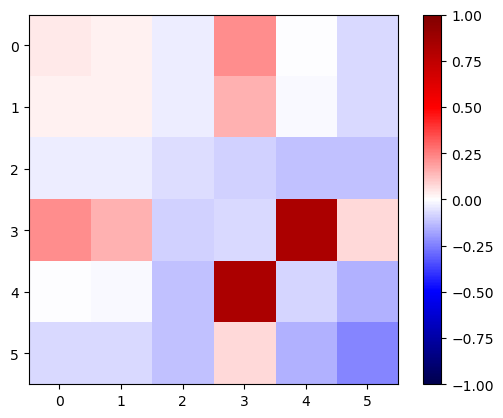

In [13]:
fig, ax = plt.subplots()
c = ax.imshow((np.cov(r_1e6[:6])-np.cov(gt[:6]))/np.cov(gt[:6]), cmap='seismic', vmin=-1, vmax=1)
fig.colorbar(c)

# 3D scan vs 'T' scan

In [14]:
gt_2 = torch.load(os.path.join(t_scan_dir, 'non_gaussian_beam.pt')).numpy_particles()
r_3d = torch.load(os.path.join(t_scan_dir, '3D_scan_100_000.pt')).numpy_particles()
r_t = torch.load(os.path.join(t_scan_dir, 't_scan_100_000.pt')).numpy_particles()

6


/tmp/ipykernel_6689/2807903281.py:209: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


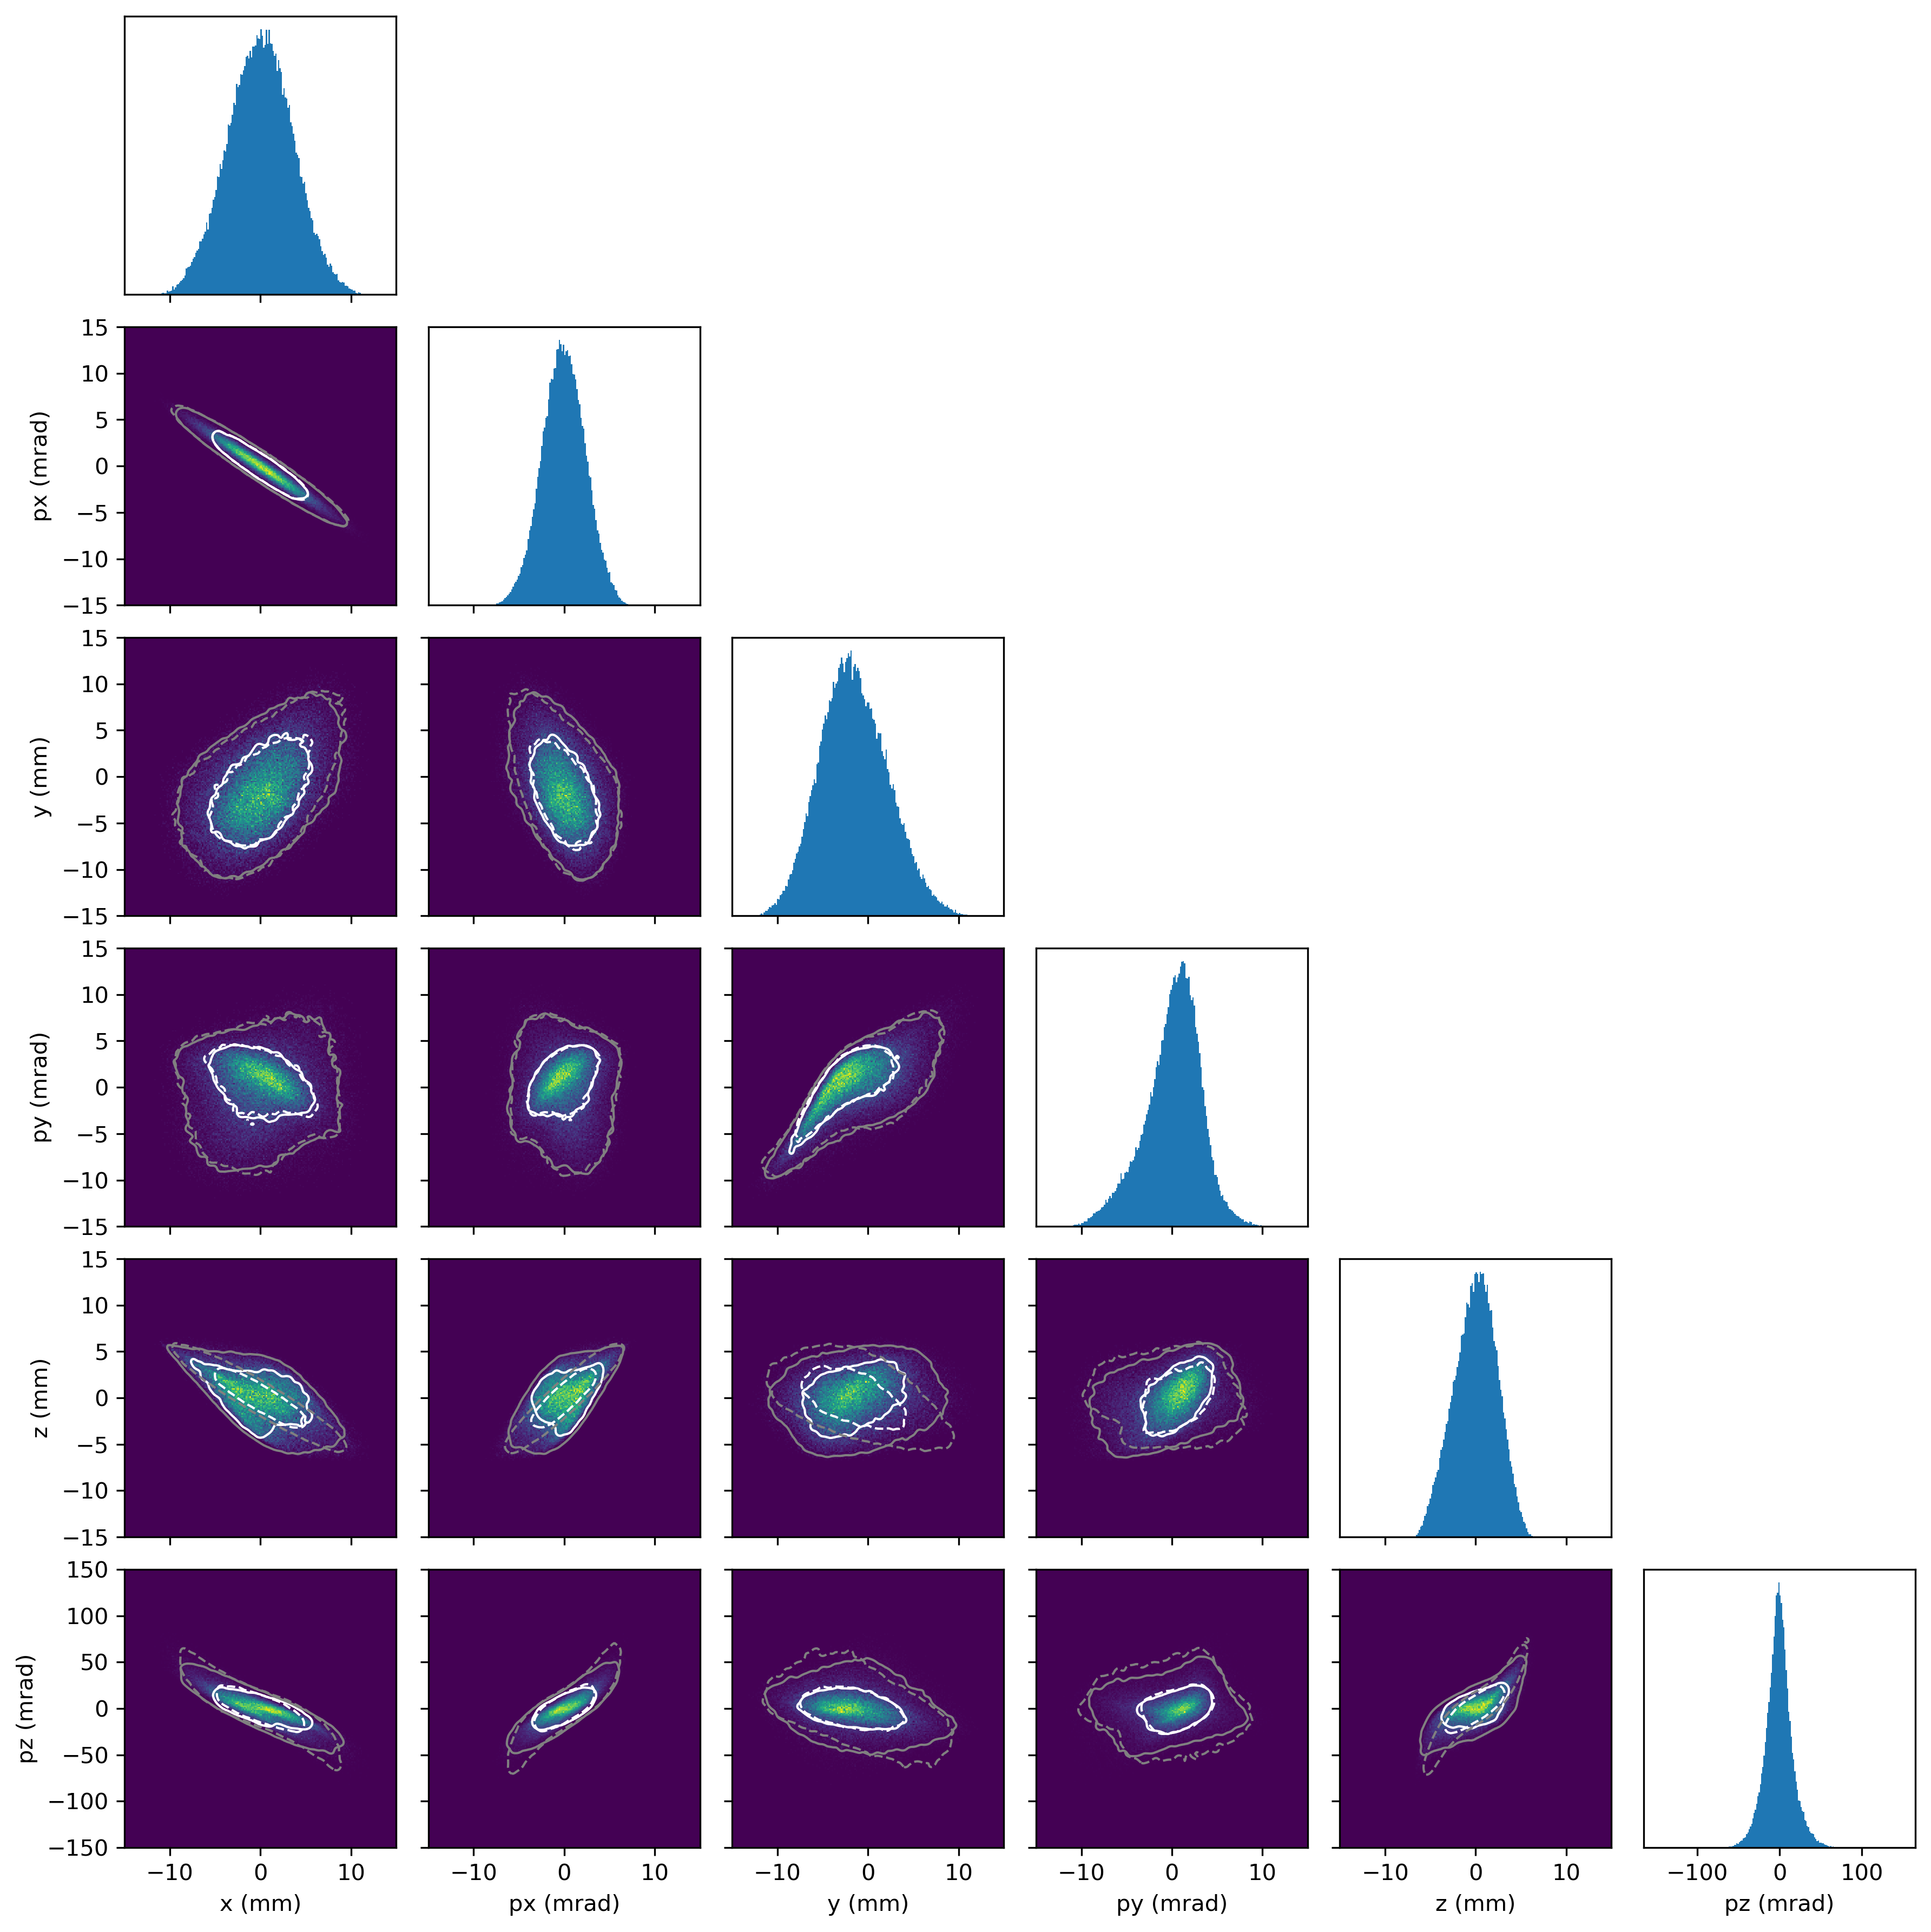

In [15]:
plot_projections_with_contours(
    r_t,
    gt_2,
    bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=2,
    contour_smoothing_gt=2
)
plt.show()

In [16]:
print(np.cov(r_3d[:6])*1e6)
print(np.cov(r_t[:6])*1e6)
print(np.cov(gt_2[:6])*1e6)

[[12.717 -8.163 7.158 -0.586 -7.252 -60.838]
 [-8.163 5.492 -4.689 0.312 4.742 40.422]
 [7.158 -4.689 14.235 8.709 -4.128 -34.809]
 [-0.586 0.312 8.709 9.765 0.393 3.615]
 [-7.252 4.742 -4.128 0.393 4.256 35.729]
 [-60.838 40.422 -34.809 3.615 35.729 325.982]]
[[12.865 -8.262 6.217 0.009 -5.110 -52.997]
 [-8.262 5.545 -3.691 0.242 3.435 34.769]
 [6.217 -3.691 13.950 8.585 1.808 -15.732]
 [0.009 0.242 8.585 9.568 2.891 12.439]
 [-5.110 3.435 1.808 2.891 5.475 28.683]
 [-52.997 34.769 -15.732 12.439 28.683 276.002]]
[[13.568 -8.662 7.728 -0.679 -7.681 -69.044]
 [-8.662 5.778 -4.964 0.434 4.996 44.905]
 [7.728 -4.964 15.003 9.006 -4.464 -39.960]
 [-0.679 0.434 9.006 9.924 0.390 3.316]
 [-7.681 4.996 -4.464 0.390 4.680 42.054]
 [-69.044 44.905 -39.960 3.316 42.054 430.854]]


In [17]:
print((np.cov(r_3d[:6])-np.cov(gt_2[:6]))*1e6)
print((np.cov(r_t[:6])-np.cov(gt_2[:6]))*1e6)

[[-0.851 0.498 -0.570 0.093 0.428 8.206]
 [0.498 -0.286 0.274 -0.122 -0.254 -4.483]
 [-0.570 0.274 -0.769 -0.297 0.336 5.151]
 [0.093 -0.122 -0.297 -0.159 0.002 0.299]
 [0.428 -0.254 0.336 0.002 -0.424 -6.325]
 [8.206 -4.483 5.151 0.299 -6.325 -104.872]]
[[-0.703 0.400 -1.511 0.688 2.571 16.047]
 [0.400 -0.233 1.273 -0.192 -1.561 -10.136]
 [-1.511 1.273 -1.053 -0.421 6.272 24.228]
 [0.688 -0.192 -0.421 -0.356 2.500 9.122]
 [2.571 -1.561 6.272 2.500 0.795 -13.371]
 [16.047 -10.136 24.228 9.122 -13.371 -154.852]]


In [18]:
print((np.cov(r_3d[:6])-np.cov(gt_2[:6]))/np.cov(gt_2[:6]))
print((np.cov(r_t[:6])-np.cov(gt_2[:6]))/np.cov(gt_2[:6]))

[[-0.063 -0.058 -0.074 -0.137 -0.056 -0.119]
 [-0.058 -0.049 -0.055 -0.281 -0.051 -0.100]
 [-0.074 -0.055 -0.051 -0.033 -0.075 -0.129]
 [-0.137 -0.281 -0.033 -0.016 0.005 0.090]
 [-0.056 -0.051 -0.075 0.005 -0.091 -0.150]
 [-0.119 -0.100 -0.129 0.090 -0.150 -0.243]]
[[-0.052 -0.046 -0.196 -1.013 -0.335 -0.232]
 [-0.046 -0.040 -0.256 -0.442 -0.312 -0.226]
 [-0.196 -0.256 -0.070 -0.047 -1.405 -0.606]
 [-1.013 -0.442 -0.047 -0.036 6.403 2.751]
 [-0.335 -0.312 -1.405 6.403 0.170 -0.318]
 [-0.232 -0.226 -0.606 2.751 -0.318 -0.359]]


In [39]:
def get_cov(particle, gt_particle=None, relative=False, scale=1e6):
    cov = np.cov(particle[:6])*scale

    if gt_particle is None:
        return cov
    
    else:
        gt_cov = np.cov(gt_particle[:6])*scale

        if relative:
            return (cov - gt_cov)/gt_cov
        
        else:
            return cov-gt_cov

def plot_cov(cov, vmin=None, vmax=None):
    fig, ax = plt.subplots()
    c = ax.imshow(cov, cmap='coolwarm', vmin=vmin, vmax=vmax)
    for (j,i), label in np.ndenumerate(cov):
        ax.text(i, j, f'{label:.3f}', ha='center', va='center')
    fig.colorbar(c)

In [40]:
# beam fractions:
gt_50 = get_beam_fraction_bmadx_particle(gt, .50)
gt_95 = get_beam_fraction_bmadx_particle(gt, .95)
r_1e4_50 = get_beam_fraction_bmadx_particle(r_1e4, .50)
r_1e4_95 = get_beam_fraction_bmadx_particle(r_1e4, .95)
r_1e5_50 = get_beam_fraction_bmadx_particle(r_1e5, .50)
r_1e5_95 = get_beam_fraction_bmadx_particle(r_1e5, .95)
r_1e6_50 = get_beam_fraction_bmadx_particle(r_1e6, .50)
r_1e6_95 = get_beam_fraction_bmadx_particle(r_1e6, .95)
r_3d_50 = get_beam_fraction_bmadx_particle(r_3d, .50)
r_t_95 = get_beam_fraction_bmadx_particle(r_t, .95)

In [41]:
print(np.shape(gt_50.x))

(500000,)


[[-0.186 -0.191 -0.217 0.172 -0.191 -0.273]
 [-0.191 -0.194 -0.203 0.081 -0.205 -0.259]
 [-0.217 -0.203 -0.092 -0.071 -0.241 -0.255]
 [0.172 0.081 -0.071 -0.100 -0.103 -0.672]
 [-0.191 -0.205 -0.241 -0.103 -0.246 -0.315]
 [-0.273 -0.259 -0.255 -0.672 -0.315 -0.413]]
[[-0.153 -0.155 -0.115 -0.471 -0.175 -0.229]
 [-0.155 -0.150 -0.098 -0.550 -0.182 -0.208]
 [-0.115 -0.098 0.080 0.201 -0.149 -0.140]
 [-0.471 -0.550 0.201 0.136 -0.699 -1.168]
 [-0.175 -0.182 -0.149 -0.699 -0.231 -0.275]
 [-0.229 -0.208 -0.140 -1.168 -0.275 -0.326]]
[[-0.160 -0.165 -0.184 -0.103 -0.163 -0.208]
 [-0.165 -0.168 -0.166 -0.171 -0.178 -0.189]
 [-0.184 -0.166 -0.025 0.014 -0.206 -0.166]
 [-0.103 -0.171 0.014 -0.025 -0.338 -0.859]
 [-0.163 -0.178 -0.206 -0.338 -0.221 -0.254]
 [-0.208 -0.189 -0.166 -0.859 -0.254 -0.302]]
[[13.562 -8.660 7.807 -0.581 -7.684 -69.245]
 [-8.660 5.778 -5.010 0.376 4.999 45.055]
 [7.807 -5.010 15.109 9.069 -4.508 -40.609]
 [-0.581 0.376 9.069 9.935 0.337 2.707]
 [-7.684 4.999 -4.508 0.33

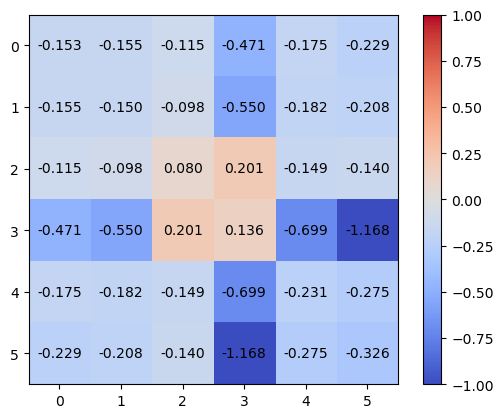

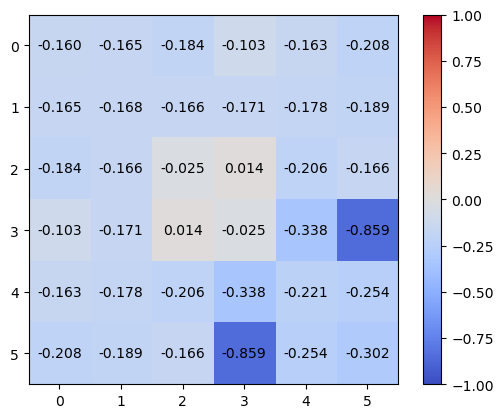

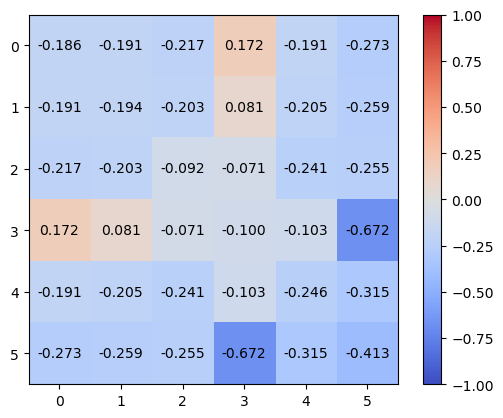

In [42]:
vmin = -1
vmax = 1
cov_1e4_50 = get_cov(r_1e4_50, gt_50, relative=True)
plot_cov(cov_1e4_50, vmin=vmin, vmax=vmax)
cov_1e4_95 = get_cov(r_1e4_95, gt_95, relative=True)
plot_cov(cov_1e4_95, vmin=vmin, vmax=vmax)
cov_1e4 = get_cov(r_1e4, gt, relative=True)
plot_cov(cov_1e4, vmin=vmin, vmax=vmax)
print(cov_1e4)
print(cov_1e4_50)
print(cov_1e4_95)
print(get_cov(gt))

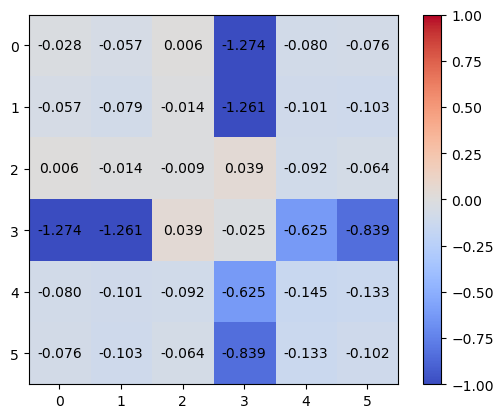

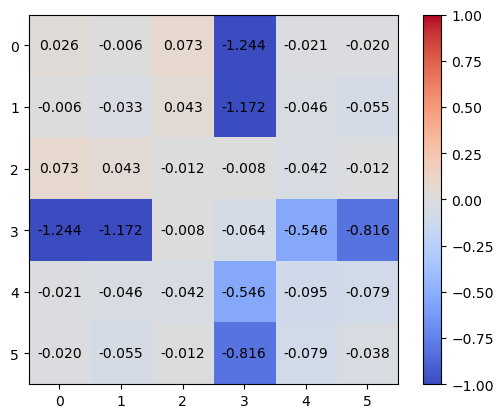

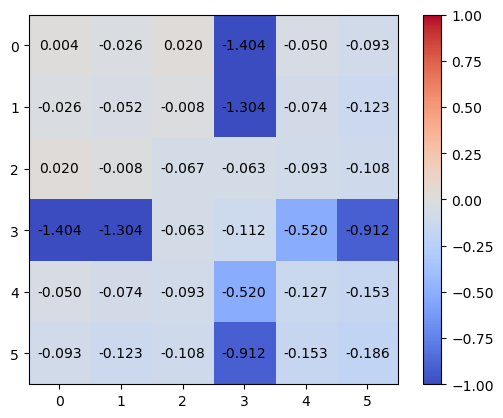

In [43]:
cov_1e5_50 = get_cov(r_1e5_50, gt_50, relative=True)
plot_cov(cov_1e5_50, vmin=vmin, vmax=vmax)
cov_1e5_95 = get_cov(r_1e5_95, gt_95, relative=True)
plot_cov(cov_1e5_95, vmin=vmin, vmax=vmax)
cov_1e5 = get_cov(r_1e5, gt, relative=True)
plot_cov(cov_1e5, vmin=vmin, vmax=vmax)

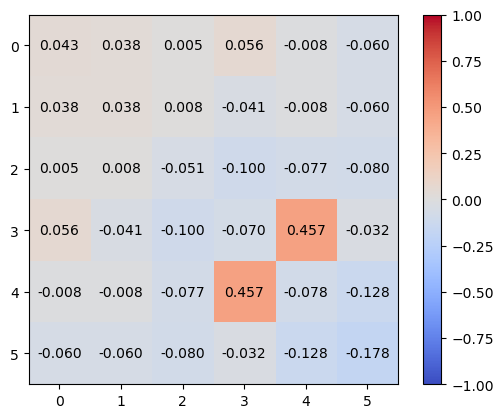

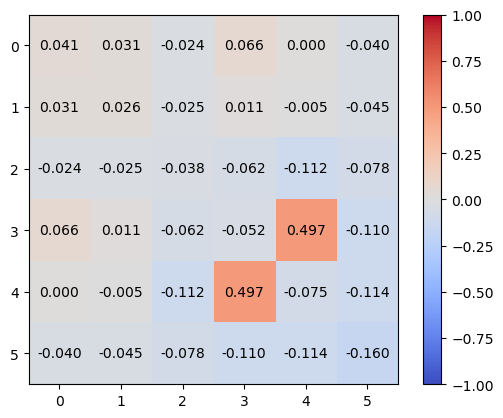

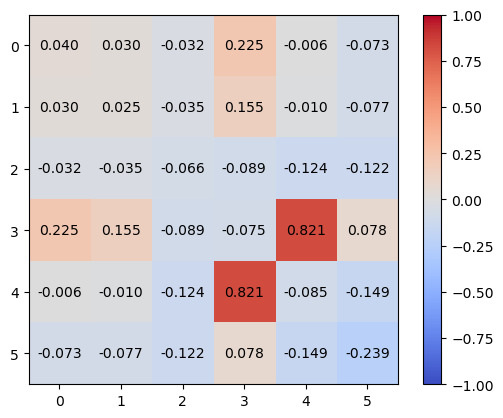

In [44]:
cov_1e6_50 = get_cov(r_1e6_50, gt_50, relative=True)
plot_cov(cov_1e6_50, vmin=vmin, vmax=vmax)
cov_1e6_95 = get_cov(r_1e6_95, gt_95, relative=True)
plot_cov(cov_1e6_95, vmin=vmin, vmax=vmax)
cov_1e6 = get_cov(r_1e6, gt, relative=True)
plot_cov(cov_1e6, vmin=vmin, vmax=vmax)

In [25]:
print(get_cov(gt_50))
print(get_cov(gt_95))
print(get_cov(gt))

[[10.946 -6.999 6.789 -0.554 -6.230 -49.689]
 [-6.999 4.615 -4.357 0.356 4.035 32.197]
 [6.789 -4.357 11.031 5.657 -3.914 -30.885]
 [-0.554 0.356 5.657 6.039 0.322 2.806]
 [-6.230 4.035 -3.914 0.322 3.734 29.836]
 [-49.689 32.197 -30.885 2.806 29.836 258.269]]
[[12.016 -7.662 6.830 -0.731 -6.769 -55.453]
 [-7.662 5.115 -4.378 0.470 4.402 36.067]
 [6.830 -4.378 13.632 8.282 -3.924 -32.094]
 [-0.731 0.470 8.282 9.117 0.422 3.413]
 [-6.769 4.402 -3.924 0.422 4.119 33.777]
 [-55.453 36.067 -32.094 3.413 33.777 307.038]]
[[13.562 -8.660 7.807 -0.581 -7.684 -69.245]
 [-8.660 5.778 -5.010 0.376 4.999 45.055]
 [7.807 -5.010 15.109 9.069 -4.508 -40.609]
 [-0.581 0.376 9.069 9.935 0.337 2.707]
 [-7.684 4.999 -4.508 0.337 4.686 42.234]
 [-69.245 45.055 -40.609 2.707 42.234 435.192]]
